In [16]:
import dolphindb as ddb
import matplotlib.pyplot as plt
import pandas as pd


def draw():
    pass

def backtest(factor):
    def core(num):
        sess = ddb.session(host='localhost', port=8848, userid='admin', password='123456')
        sess.run("factor = table(1000:0,`trade_time`instrument`factor_value, [TIMESTAMP,SYMBOL,DOUBLE])")
        sess.run("tableInsert{factor}",factor)
        sess.run(f"num = {num}")
        df: pd.DataFrame = sess.runFile("backtest.dos")
        sess.close()
        return df
    
    df_2 = core(2)
    df_2.set_index("trade_time").groupby('grp')['af_rev'].plot(legend=True)
    
    return df_2

In [17]:
factor6 = """
use wq101alpha
instruments = select instrument from (select min(trade_time) as min, instrument from loadTable("dfs://crypto_db", "k_hour") group by instrument) where min < 2021.01.01

instruments_ohlc = select trade_time, instrument, open, volume from loadTable("dfs://crypto_db", "k_hour") where trade_time >= 2021.01.01 and trade_time <= 2023.11.15 and instrument in instruments
t = select instrument, trade_time, volume, open from instruments_ohlc where date(trade_time) between 2021.01.01 : 2023.11.15
data = dict(`vol`open, panel(t.trade_time, t.instrument, [t.volume, t.open]))
alpha = WQAlpha6(data.vol, data.open)
alpha = move(alpha, 1)
factor = table(alpha.rowNames() as trade_time, alpha)
factor = factor.unpivot(`trade_time, factor.columnNames()[1:])
factor.rename!(`trade_time`instrument`factor_value)
factor = select timestamp(trade_time) as trade_time, instrument, factor_value from factor where factor_value is not null
factor
"""

                 trade_time instrument  factor_value
0       2021-01-01 01:00:00  1INCHUSDT     -0.016838
1       2021-01-01 02:00:00  1INCHUSDT     -0.042194
2       2021-01-01 03:00:00  1INCHUSDT     -0.011535
3       2021-01-01 04:00:00  1INCHUSDT      0.028546
4       2021-01-01 05:00:00  1INCHUSDT     -0.020056
...                     ...        ...           ...
1961823 2023-11-14 20:00:00    ZRXUSDT     -0.041961
1961824 2023-11-14 21:00:00    ZRXUSDT      0.012391
1961825 2023-11-14 22:00:00    ZRXUSDT     -0.030974
1961826 2023-11-14 23:00:00    ZRXUSDT     -0.007986
1961827 2023-11-15 00:00:00    ZRXUSDT      0.007923

[1961828 rows x 3 columns]


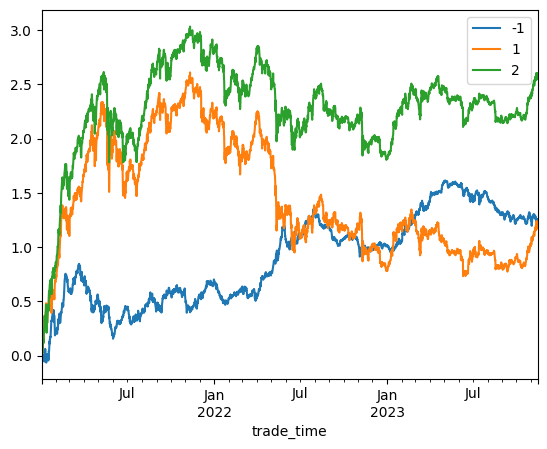

In [20]:
sess = ddb.session(host='localhost', port=8848, userid='admin', password='123456')
df = sess.runFile('factors/factor1.dos')
# df['factor_value'] = -df['factor_value']
print(df)
sess.close()
result_2 = backtest(df)

In [ ]:
result_2

,trade_time,grp,cumret,cnt,cumfee,af_rev
0,2021-01-01 16:00:00,1,0.022196,39,0.000123,0.022073
1,2021-01-02 00:00:00,1,0.015365,39,0.000222,0.015144
2,2021-01-02 08:00:00,1,0.013228,39,0.000320,0.012908
3,2021-01-02 16:00:00,1,0.028170,39,0.000455,0.027715
4,2021-01-03 00:00:00,1,0.012209,39,0.000566,0.011643
...,...,...,...,...,...,...
9424,2023-11-13 16:00:00,-1,1.909178,0,1.438399,0.470779
9425,2023-11-14 00:00:00,-1,1.898925,0,1.438817,0.460108
9426,2023-11-14 08:00:00,-1,1.899303,0,1.439334,0.459969
9427,2023-11-14 16:00:00,-1,1.903858,0,1.439950,0.463909
